# 🔧 Environment Setup and Dependencies

Before we begin, let's install the required packages. This RAG implementation uses several key libraries:

- **`docling`**: Advanced PDF parsing and document structure extraction
- **`sentence-transformers`**: Pre-trained models for text embeddings
- **`pymilvus`**: Python client for Milvus vector database
- **`langchain-openai`**: LLM integration and prompt templating
- **`boto3`**: AWS/MinIO S3 client for object storage
- **`httpx`**: HTTP client for API calls
- **`tqdm`**: Progress bars for better user experience

> **Note**: The installation may take a few minutes as it downloads pre-trained models and dependencies.


In [1]:
!uv pip install -r requirements.txt

Using Python 3.11.11 environment at: /opt/app-root
Audited 10 packages in 21ms


In [2]:
# Core Python libraries
import os
import json
import sys
from pathlib import Path

# Object storage and cloud services
import boto3
from botocore.config import Config

# Document processing and parsing
from docling.document_converter import DocumentConverter
from docling_core.transforms.chunker.hierarchical_chunker import HierarchicalChunker

# Vector database
from pymilvus import connections, utility, Collection, CollectionSchema, FieldSchema, DataType

# LLM integration and prompt management
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts.chat import SystemMessagePromptTemplate, HumanMessagePromptTemplate

# HTTP client for API calls
import httpx

# Matplotlib for visualization
import matplotlib.pyplot as plt
# PCA for dimensionality reduction
from sklearn.decomposition import PCA

# Progress tracking for user experience
from tqdm import tqdm

/opt/app-root/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ⚙️ Configuration and Connection Setup

This section configures the various services our RAG system depends on:

## Object Storage Configuration
- **MinIO/S3**: For storing and retrieving source documents
- **Bucket and Object**: Specifies which document to process

## Model and Database Configuration
- **Embedding Model**: The SentenceTransformer model for text embeddings
- **Vector Database**: Milvus connection details
- **LLM Endpoint**: The inference server for generating responses

> **Environment Variables**: These configurations are typically stored as environment variables for security and flexibility across different deployment environments.


In [3]:
# ===== STORAGE CONFIGURATION =====
# MinIO/S3 object storage settings - used for retrieving source documents
endpoint = os.getenv("AWS_S3_ENDPOINT")           # MinIO service DNS name (e.g. minio.minio.svc.cluster.local)
access_key = os.getenv("AWS_ACCESS_KEY_ID")       # MinIO access key credentials
secret_key = os.getenv("AWS_SECRET_ACCESS_KEY")   # MinIO secret key credentials
region = os.getenv("AWS_DEFAULT_REGION")          # AWS region (dummy value for MinIO)
bucket_name = os.getenv("AWS_S3_BUCKET")          # Bucket containing our source documents
object_key = "2502.07835v1.pdf"                   # Specific PDF document to process (research paper on AI code assessment)
download_dir = "downloads"                        # Local directory for downloaded documents

# ===== MODEL AND INFERENCE CONFIGURATION =====
# LLM inference server - provides the generation capabilities for RAG responses
# Default to a known default if the environment variable is not defined.
inference_server_url = os.getenv("INFERENCE_SERVER_URL", "http://llama3-2-3b-predictor.llama-serving.svc.cluster.local:8080/v1")
inference_server_model_name = os.getenv("INFERENCE_SERVER_MODEL_NAME", "llama3-2-3b")

# Vector database configuration
milvus_url = "http://milvus-service.milvus.svc.cluster.local:19530"
collection_name = "my_rag_collection"

# Embedding model configuration
embedding_model_name = "all-MiniLM-L6-v2"  # Lightweight, effective model for semantic similarity

print("🔧 Configuration loaded successfully!")
print(f"🪣 Bucket containing files: {bucket_name}")
print(f"📁 Document to process: {object_key}")
print(f"🔗 Inference server: {inference_server_url}")
print(f"🔗 Inference model name: {inference_server_model_name}")
print(f"🗃️ Vector database: {milvus_url}")
print(f"🧠 Embedding model: {embedding_model_name}")

🔧 Configuration loaded successfully!
🪣 Bucket containing files: rag-docs
📁 Document to process: 2502.07835v1.pdf
🔗 Inference server: http://llama3-2-3b-predictor.llama-serving.svc.cluster.local:8080/v1
🔗 Inference model name: llama3-2-3b
🗃️ Vector database: http://milvus-service.milvus.svc.cluster.local:19530
🧠 Embedding model: all-MiniLM-L6-v2


## 🪣 Connect to the s3 storage to retrieve the documents

In [4]:
# ===== INITIALIZE S3/MINIO CLIENT =====
# Create boto3 client configured for MinIO (S3-compatible object storage)
s3 = boto3.client(
    "s3",
    endpoint_url=f"http://{endpoint}",        # MinIO endpoint URL
    aws_access_key_id=access_key,             # Authentication credentials
    aws_secret_access_key=secret_key,
    region_name=region,                       # Required by boto3, but not used by MinIO
    config=Config(signature_version="s3v4"),  # S3 signature version for authentication
)

# ===== PREPARE LOCAL STORAGE =====
# Create local directory to store downloaded documents
os.makedirs(download_dir, exist_ok=True)
local_path = os.path.join(download_dir, object_key)

print(f"📥 Preparing to download document...")
print(f"   Source: {bucket_name}/{object_key}")
print(f"   Destination: {local_path}")

# ===== DOWNLOAD DOCUMENT =====
# Download the PDF document from object storage with proper error handling
try:
    print(f"🔄 Downloading document for processing...")
    s3.download_file(bucket_name, object_key, local_path)
    print(f"✅ Successfully downloaded '{object_key}' to '{local_path}'")
    
    # Verify the file was downloaded and get its size
    file_size = os.path.getsize(local_path)
    print(f"📊 File size: {file_size:,} bytes ({file_size/1024/1024:.1f} MB)")
    
except s3.exceptions.NoSuchKey:
    print(f"❌ ERROR: File '{object_key}' not found in bucket '{bucket_name}'")
    print("   Please check the bucket name and object key are correct.")
except Exception as e:
    print(f"❌ ERROR: Failed to download file: {e}")
    print("   Please check your MinIO/S3 configuration and network connectivity.")

📥 Preparing to download document...
   Source: rag-docs/2502.07835v1.pdf
   Destination: downloads/2502.07835v1.pdf
🔄 Downloading document for processing...
✅ Successfully downloaded '2502.07835v1.pdf' to 'downloads/2502.07835v1.pdf'
📊 File size: 1,870,265 bytes (1.8 MB)


---
# 📄 Docling: Preparing Text for RAG Systems

**Docling** is used to prepare documents for Retrieval-Augmented Generation (RAG) systems.

Text documents such as PDFs, HTML pages, or plain text need to be **converted into chunks** that can be embedded and stored in a vector database. Docling simplifies this process by extracting, cleaning, and chunking content into well-structured semantic units.

For this lab, Docling will be used to prepare documents before they are embedded and indexed in Milvus.

---

## What is Docling?

**Docling** is a Python library designed for **document preparation** in GenAI pipelines. Its role is to transform unstructured content into structured, embeddable units, typically for use in:

- **RAG applications**: Extracting retrievable units from long documents
- **Semantic search pipelines**: Chunking content into searchable segments
- **LLM input pipelines**: Creating well-scoped context windows

Docling is particularly useful for converting complex documents like PDFs into consistent formats that can be embedded by LLMs.

---

## Why Use Docling?

**Docling** provides:

- **Multi-format support**: PDF, DOCX, TXT, Markdown, HTML
- **Intelligent chunking**: Preserves context while segmenting content
- **Metadata extraction**: Title, headers, sections, and more
- **Customisable workflows**: Fine-tune chunk size, overlap, and cleaning
- **Streamlined RAG integration**: Designed to fit directly into vector pipelines

---

## Key Concepts

### Chunking
- Breaks large documents into smaller parts for efficient retrieval.
- Can be based on token count, sentence boundaries, or structure (e.g. headings).
- Prevents LLMs from exceeding context window limits.

### Overlap
- Ensures context is preserved across chunks.
- Helpful in maintaining continuity of thought or narrative.

### Metadata
- Docling can attach metadata (e.g. file name, page number, section header) to each chunk.
- Useful for traceability and debugging in RAG outputs.

---

## Typical Docling Workflow

1. **Load the document**
   - From local files or URLs

2. **Parse and clean**
   - Normalise spacing, remove boilerplate, handle special characters

3. **Chunk**
   - Create segments that fit within model context limits

4. **Enrich**
   - Add metadata such as section titles or page numbers

5. **Output**
   - Return a list of chunk objects ready for embedding

---

Let’s use Docling to transform raw documents into structured, retrievable content!


---
## 1. Load the document

In [5]:
from utils import project_root

# Assemble a complete path to the file so the document import can properly and reliably always find the document.
doc_source = project_root() / local_path

if not doc_source.is_file():
    raise FileNotFoundError(f"{doc_source} does not exist.")

print(f"🟢 INFO: Found document at: {doc_source}")

🟢 INFO: Found document at: /opt/app-root/src/rhoai-roadshow-v2/docs/2-rag/notebook/downloads/2502.07835v1.pdf


---
## 2. Parse and clean
First we parse the document and store it in an internal Docling format

In [6]:
"""
Parse and chunk a PDF using Docling v2.x
"""
doc = DocumentConverter().convert(source=doc_source).document

print(f"🟢 INFO: {doc.pages}")

🟢 INFO: {1: PageItem(size=Size(width=612.0, height=792.0), image=None, page_no=1), 2: PageItem(size=Size(width=612.0, height=792.0), image=None, page_no=2), 3: PageItem(size=Size(width=612.0, height=792.0), image=None, page_no=3), 4: PageItem(size=Size(width=612.0, height=792.0), image=None, page_no=4), 5: PageItem(size=Size(width=612.0, height=792.0), image=None, page_no=5), 6: PageItem(size=Size(width=612.0, height=792.0), image=None, page_no=6), 7: PageItem(size=Size(width=612.0, height=792.0), image=None, page_no=7), 8: PageItem(size=Size(width=612.0, height=792.0), image=None, page_no=8), 9: PageItem(size=Size(width=612.0, height=792.0), image=None, page_no=9), 10: PageItem(size=Size(width=612.0, height=792.0), image=None, page_no=10), 11: PageItem(size=Size(width=612.0, height=792.0), image=None, page_no=11), 12: PageItem(size=Size(width=612.0, height=792.0), image=None, page_no=12), 13: PageItem(size=Size(width=612.0, height=792.0), image=None, page_no=13)}


--- 
## 3. Chunk the document
This code loads the document and converts it to chunks that can be invididually embedded.
Once the document is chunked it can be stored in the database.

In [7]:
# ===== DOCUMENT PROCESSING AND CHUNKING =====
# Now let's process our PDF document and break it into searchable chunks
print("📄 Processing document with Docling...")

# Initialize document converter and chunker
converter = DocumentConverter()
chunker = HierarchicalChunker()

# Convert the PDF to a structured document object
print(f"   Converting PDF: {doc_source}")
doc = converter.convert(source=doc_source).document

# Analyze document structure
print(f"📊 DOCUMENT ANALYSIS:")
print(f"   • Total pages: {len(doc.pages)}")
print(f"   • Document type: {type(doc)}")

# Document metadata would be available here if the document contained it
print(f"   • Processing strategy: Structure-aware parsing")

# Perform hierarchical chunking
print(f"\n🔪 Chunking document into smaller pieces...")
print(f"   • Strategy: Hierarchical chunking")
print(f"   • Benefits: Preserves document structure and context")

# Extract text chunks from the document
texts = [chunk.text for chunk in chunker.chunk(doc)]

print(f"📈 CHUNKING RESULTS:")
print(f"   • Total chunks created: {len(texts)}")
print(f"   • Average chunk length: {sum(len(text) for text in texts) / len(texts):.0f} characters")
print(f"   • Shortest chunk: {min(len(text) for text in texts)} characters")
max_chunk_size = max(len(text) for text in texts)             # This is needed for defining the Milvus schema.
print(f"   • Longest chunk: {max_chunk_size} characters")

# Show a sample chunk
print(f"\n📝 SAMPLE CHUNK (first 200 characters):")
print(f"   \"{texts[0][:200]}...\"")

print(f"\n✅ Document processing complete! Ready for embedding generation.")

📄 Processing document with Docling...
   Converting PDF: /opt/app-root/src/rhoai-roadshow-v2/docs/2-rag/notebook/downloads/2502.07835v1.pdf
📊 DOCUMENT ANALYSIS:
   • Total pages: 13
   • Document type: <class 'docling_core.types.doc.document.DoclingDocument'>
   • Processing strategy: Structure-aware parsing

🔪 Chunking document into smaller pieces...
   • Strategy: Hierarchical chunking
   • Benefits: Preserves document structure and context
📈 CHUNKING RESULTS:
   • Total chunks created: 70
   • Average chunk length: 326 characters
   • Shortest chunk: 6 characters
   • Longest chunk: 1545 characters

📝 SAMPLE CHUNK (first 200 characters):
   "ahilanp@gmail.com..."

✅ Document processing complete! Ready for embedding generation.


---
## 4. Enrich
We won't be doing any enrichment in this lab.

---
## 5. Output
Because we are not enriching the documents we already have the output from step 3.

---
# Embedding the the document chunks
As we saw in the previous activity, whenever we store our objects in a vector database we need to convert them to a vector. To do that we need an embedding model.

## Configure the transformer model for embedding the documents

In [8]:
from sentence_transformers import SentenceTransformer

# Select the model we will use for embedding chunks
embedding_model="all-MiniLM-L6-v2"
model = SentenceTransformer(embedding_model)

In [9]:
# Here we have created a simple helper function `emb_text()` that we will use when we embed the chunks.
"""
Text Embedding Module  
This module initialises a SentenceTransformer model using the ‘all-MiniLM-L6-v2’ embedding model and provides a function to generate text embeddings.

Global Variables:
    embedding_model (str): Name of the Hugging Face embedding model to load.
    model (SentenceTransformer): Instance of SentenceTransformer initialised with the specified embedding model.

Functions:
    emb_text(text: str) -> list[float]:
        Encode the input text and return its embedding vector as a list of floats.
"""
def emb_text(text: str) -> list[float]:
    return model.encode(text)

## Test the embedding is working and also extract the dimensions
This next code not only tests the embedding is working, but also determines the dimensions that the embedding model generates. We need that number for when we define the vector database schema later on.

In [10]:
# ===== EMBEDDING DIMENSION EXPLORATION =====
# Test our embedding function to understand the output format and dimensions
# This information is crucial for configuring the vector database schema

print("🧪 Testing embedding function with sample text...")
test_text = "This is a test sentence to demonstrate text embeddings."
test_embedding = emb_text(test_text)
embedding_dim = len(test_embedding)

print(f"📊 EMBEDDING ANALYSIS:")
print(f"   • Input text: '{test_text}'")
print(f"   • Embedding dimensions: {embedding_dim}")    # We need this value when we define the Milvus schema
print(f"   • Data type: {type(test_embedding)}")
print(f"   • Sample values: {test_embedding[:10]}")
print(f"   • Value range: [{min(test_embedding):.4f}, {max(test_embedding):.4f}]")


🧪 Testing embedding function with sample text...
📊 EMBEDDING ANALYSIS:
   • Input text: 'This is a test sentence to demonstrate text embeddings.'
   • Embedding dimensions: 384
   • Data type: <class 'numpy.ndarray'>
   • Sample values: [-0.00573698  0.00202521  0.07564172  0.0383721   0.02895643  0.0611613
 -0.01208316 -0.01273861  0.02499382 -0.04949658]
   • Value range: [-0.1730, 0.1419]


## Create the embeddings (vectors) for all of the document chunks 
Iterate through all of the chunks and creayte an embedding vecotr for them. Later we will store these in the vector database

In [11]:
# ===== EMBEDDING GENERATION AND STORAGE =====
print("🔄 Generating embeddings for all document chunks...")
print(f"   Processing {len(texts)} chunks with {embedding_model_name}")

# Prepare data structure for batch insertion (Milvus expects a list of dicts)
data = []
embeddings_list = []  # 🔹 Collect embeddings for plotting PCA below
total_tokens = 0
doc_name = object_key  # This is the file name that we are embedding

# Process each chunk: generate embedding and prepare for storage
for i, chunk in enumerate(tqdm(texts, desc="🧮 Embedding chunks")):
    # Generate embedding for this chunk
    embedding = emb_text(chunk)
    
    # Add embedding to list for PCA plotting below
    embeddings_list.append(embedding)

    # Prepare record for Milvus
    data.append({
        "id": i,                             # Unique identifier for this chunk
        "embedding": embedding.tolist(),     # Convert the vectyor to a list for Milvus
        "original_text" : chunk,             # The original text in the chunk
        "metadata": doc_name                 # Constant metadata
    })
    
    # Track statistics
    total_tokens += len(chunk.split())

# Display embedding statistics
print(f"\n📊 EMBEDDING STATISTICS:")
print(f"   • Total chunks embedded: {len(data)}")
print(f"   • Total words processed: {total_tokens:,}")
print(f"   • Average words per chunk: {total_tokens/len(data):.1f}")
print(f"   • Embedding dimensions: {len(data[0]['embedding'])}")
print(f"   • Memory usage: ~{len(data) * len(data[0]['embedding']) * 4 / 1024 / 1024:.1f} MB")

🔄 Generating embeddings for all document chunks...
   Processing 70 chunks with all-MiniLM-L6-v2


🧮 Embedding chunks: 100%|██████████| 70/70 [00:00<00:00, 185.71it/s]


📊 EMBEDDING STATISTICS:
   • Total chunks embedded: 70
   • Total words processed: 3,313
   • Average words per chunk: 47.3
   • Embedding dimensions: 384
   • Memory usage: ~0.1 MB


# 📊 Visualizing Vector Embeddings (Optional Educational Step)

## Understanding Vector Spaces

Embeddings exist in high-dimensional space (384 dimensions in our case), which is difficult to visualize directly. However, we can use dimensionality reduction techniques to project these vectors into 2D or 3D space for visualization.

## Tools for Visualization

### TensorFlow Projector
- **URL**: https://projector.tensorflow.org/
- **Purpose**: Interactive visualization of high-dimensional embeddings
- **Features**: 
  - PCA and t-SNE dimensionality reduction
  - Color-coding and clustering
  - Interactive exploration of vector neighborhoods

### How It Works

1. **Dimensionality Reduction**: Algorithms like PCA or t-SNE compress 384D vectors to 2D/3D
2. **Semantic Clustering**: Similar concepts appear close together in the visualization
3. **Interactive Exploration**: Click on points to see the original text and find similar chunks

## What You Would See

- **Document Clusters**: Related sections of the paper grouped together
- **Concept Boundaries**: Clear separation between different topics
- **Similarity Relationships**: Semantic connections between text chunks

## Educational Value

Visualizing embeddings helps you understand:
- How semantic similarity translates to geometric proximity
- Why vector search is effective for finding related content
- The relationship between embedding quality and retrieval performance

> **Note**: While visualization is helpful for understanding, it's optional for the RAG system functionality. The vector database performs searches directly in the high-dimensional space without needing to reduce dimensions.

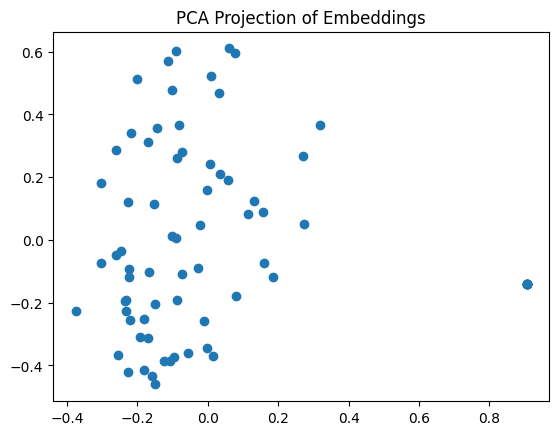

In [12]:
# Visualise our embeddings using dimensionality reduction to plot the embedded chunks in two dimensions.  
# Unlike the previous exercise, we won't print the text with the plot because the text is too long.
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings_list)
plt.scatter(reduced[:, 0], reduced[:, 1])
plt.title("PCA Projection of Embeddings")
plt.show()

---
# Connect to Milvus
We want to store all of the embedded chunks in the vector database. Let's create a new database to do this

In [13]:
# Connect to Milvus first
connections.connect(alias="simple_rag", uri=milvus_url)

# Test the connection
try:
    # List existing collections to verify connectivity
    existing_collections = utility.list_collections(using="simple_rag")
    
    print(f"✅ Successfully connected to Milvus!")
    print(f"   Endpoint: {milvus_url}")
    print(f"   Existing collections: {existing_collections}")
    print(f"   Target collection: {collection_name}")
except Exception as e:
    print(f"❌ Failed to connect to Milvus: {e}")
    print("   Please check that Milvus is running and accessible.")
    sys.exit("❌ Fatal error, stopping execution")

# Define the collection name
collection_name = "vectordb_collection"

✅ Successfully connected to Milvus!
   Endpoint: http://milvus-service.milvus.svc.cluster.local:19530
   Existing collections: ['vectordb_collection', 'rag_vector_db', 'my_rag_collection']
   Target collection: my_rag_collection


In [14]:
# If the collection already exists, drop it for a clean start (optional)
if utility.has_collection(collection_name, using="simple_rag"):
    print(f"⚠️ Collection '{collection_name}' already exists. Dropping for clean run.")
    utility.drop_collection(collection_name, using="simple_rag")

print(f"📚 Collection list: {utility.list_collections(using='simple_rag')}")

⚠️ Collection 'vectordb_collection' already exists. Dropping for clean run.
📚 Collection list: ['rag_vector_db', 'my_rag_collection']


## Milvus Setup: Define the schema now we have created it

In [15]:
# Define schema after connecting
id_field = FieldSchema(
    name="id",
    dtype=DataType.INT64,
    is_primary=True,
    auto_id=False
)

# This will contain the embedding vectors
embedding_field = FieldSchema(
        name="embedding",
        dtype=DataType.FLOAT_VECTOR,
        dim=embedding_dim
    )

# This will contain the original text so we can use it with the LLM.
text_field = FieldSchema(
    name="original_text",
    dtype=DataType.VARCHAR,
    max_length=max_chunk_size    # This is calculated when we chunked the document.
)

# This will contain the embedding metadata (source document in our example)
doc_field = FieldSchema(
    name="metadata",
    dtype=DataType.VARCHAR,
    max_length=256               # This is a safe size for a URL.
)

# Create the schema using the fields defined above
schema = CollectionSchema(
    fields=[id_field, embedding_field, text_field, doc_field],
    description="Simple RAG Schema",
    enable_dynamic_field=False
)

# ✅ Create the collection now
collection = Collection(
    name=collection_name,
    schema=schema,
    using="simple_rag",
    shards_num=2
)

# Create an index on the embedding attribute
collection.create_index(
    field_name="embedding",
    index_params={
        "metric_type": "COSINE",
        "index_type": "IVF_FLAT",
        "params": {"nlist": 128}
    },
    index_name="idx"
)

print(f"📚 Collection list: {utility.list_collections(using='simple_rag')}")

📚 Collection list: ['rag_vector_db', 'my_rag_collection', 'vectordb_collection']


### Describe the collection we just created

In [16]:

# Print collection information
print("📄 Collection description:", collection.description)
print("📄 Collection schema:", collection.schema)
print("📄 Number of entities:", collection.num_entities)

# List indexes
print("📄 Indexes:", collection.indexes)

📄 Collection description: Simple RAG Schema
📄 Collection schema: {'auto_id': False, 'description': 'Simple RAG Schema', 'fields': [{'name': 'id', 'description': '', 'type': <DataType.INT64: 5>, 'is_primary': True, 'auto_id': False}, {'name': 'embedding', 'description': '', 'type': <DataType.FLOAT_VECTOR: 101>, 'params': {'dim': 384}}, {'name': 'original_text', 'description': '', 'type': <DataType.VARCHAR: 21>, 'params': {'max_length': 1545}}, {'name': 'metadata', 'description': '', 'type': <DataType.VARCHAR: 21>, 'params': {'max_length': 256}}], 'enable_dynamic_field': False}
📄 Number of entities: 0
📄 Indexes: [<pymilvus.orm.index.Index object at 0x7f2cccbe48d0>]


# 💾 Vector Storage and Search

## Understanding Vector Storage

Now that we have processed our document into chunks, we need to:

1. **Convert each chunk to embeddings**: Transform text into numerical vectors
2. **Store in vector database**: Save embeddings with metadata for efficient retrieval
3. **Index for search**: Prepare the database for fast similarity queries

## The Embedding Process

For each text chunk, we will:
- **Generate embeddings** using our SentenceTransformer model
- **Store the vector** along with the original text in Milvus
- **Create an index** for fast similarity search

## Why This Approach Works

- **Semantic Understanding**: Vector representations capture meaning, not just keywords
- **Scalability**: Vector databases handle millions of embeddings efficiently
- **Fast Retrieval**: Approximate nearest neighbor search provides quick results
- **Flexibility**: Easy to update, add, or remove documents

Let's embed our document chunks and store them in the vector database!

In [17]:
# ===== BATCH INSERT TO MILVUS =====
print(f"\n💾 Storing embeddings in Milvus vector database...")
print(f"   Records to insert: {len(data)}")

# We created the embeddings earlier and stored them in the "data" array. Now we will do a batch insert into the vector database.
insert_result = collection.insert(data=data)

# Commit the update to the database
collection.flush()
collection.load()

print(f"✅ STORAGE COMPLETE!")
print(f"   Total vectors stored: {insert_result.insert_count}")

# Verify the data was inserted correctly
collection_stats = {
    "name": collection.name,
    "description": collection.description,
    "num_entities": collection.num_entities,
    "fields": [field.name for field in collection.schema.fields]
}
print("📄 Collection stats:", collection_stats)

print(f"\n🔍 Vector database is ready for similarity search!")


💾 Storing embeddings in Milvus vector database...
   Records to insert: 70
✅ STORAGE COMPLETE!
   Total vectors stored: 70
📄 Collection stats: {'name': 'vectordb_collection', 'description': 'Simple RAG Schema', 'num_entities': 70, 'fields': ['id', 'embedding', 'original_text', 'metadata']}

🔍 Vector database is ready for similarity search!


---
# ⏸️ Checkpoint
Let's pause and recap what we have done so far...

At this point we have loaded a PDF document and converted it to chunks using Docling. We then generated vectors (embeddings) for each chunk and stored these in our vector database, along with the original text and some metadata that identifies the source document for each chunk.  

In our exercise we are only working with a single document. But in the real world you would have multiple documents and thus the metadata becomes very important so you can find what the LLM used to generate its response.

In the next section you will see how we can answer questions of our documents using the vector database and the large-language capabilities of the LLM.

___
# 🔍 Query-Time Retrieval

## How RAG Retrieval Works

When a user asks a question, the RAG system performs the following steps:

1. **Query Embedding**: Convert the user's question into the same vector space as our documents
2. **Similarity Search**: Find the most similar document chunks using vector distance
3. **Ranking**: Sort results by relevance score (similarity distance)
4. **Selection**: Choose the top-k most relevant chunks for context

## Vector Search Process

### Step 1: Query Embedding
- Use the **same embedding model** that was used for document chunks
- This ensures query and document vectors are in the same semantic space

### Step 2: Distance Calculation
- **Inner Product (IP)**: Our chosen metric - higher values mean more similar
- **Cosine Similarity**: Measures angle between vectors (normalized IP)
- **Euclidean Distance**: Straight-line distance in vector space

### Step 3: Approximate Nearest Neighbor (ANN)
- **Speed vs Accuracy**: ANN provides fast search with minimal accuracy loss
- **Indexing**: Milvus creates indexes for efficient search across millions of vectors
- **Scalability**: Can handle large document collections in real-time

## Retrieval Parameters

- **Limit**: Number of top results to return (we'll use 3)
- **Search Params**: Configuration for the search algorithm
- **Output Fields**: Which metadata to return with results (we want the original text)

Let's test our retrieval system with a sample question!

In [18]:
# ===== DEFINE USER QUERY =====
# This is the question we want to answer using our RAG system. The question is specific to the document that we saved in our vector database. The LLM has no knowledge of this topic and with out the vector database it would hallucinate the answer.
question = (
    "What are the challenges of assessing the quality of AI-generated code? What are some strategies for doing this?"
)

print("❓ USER QUESTION:")
print(f"   \"{question}\"")

# This question is perfect for testing our RAG system because:
# 1. It's directly related to our document (AI code evaluation)
# 2. It has two parts - challenges AND strategies
# 3. It requires synthesis of information from multiple sections
# 4. It's the kind of question that benefits from retrieved context

print(f"\n🎯 Why this question tests RAG effectively:")
print(f"   • Domain-specific: Related to AI code evaluation")
print(f"   • Multi-faceted: Asks for both challenges AND strategies")
print(f"   • Synthesis required: Needs information from multiple sources")
print(f"   • Context-dependent: Benefits from specific document knowledge")

❓ USER QUESTION:
   "What are the challenges of assessing the quality of AI-generated code? What are some strategies for doing this?"

🎯 Why this question tests RAG effectively:
   • Domain-specific: Related to AI code evaluation
   • Multi-faceted: Asks for both challenges AND strategies
   • Synthesis required: Needs information from multiple sources
   • Context-dependent: Benefits from specific document knowledge


In [19]:
# ===== PERFORM VECTOR SEARCH =====
# Step 1: Convert the question to an embedding vector
print("🔄 Converting question to embedding...")
question_embedding = emb_text(question)

print(f"   Question embedding shape: {len(question_embedding)} dimensions")
print(f"   Embedding sample: {question_embedding[:5]}")

# Step 2: Search for similar vectors in the database
print(f"\n🔍 Searching for similar document chunks...")
print(f"   Collection: {collection_name}")
print(f"   Search method: Vector similarity using Inner Product")
print(f"   Top results to return: 3")

🔄 Converting question to embedding...
   Question embedding shape: 384 dimensions
   Embedding sample: [-0.08172768 -0.02636518 -0.04366045  0.04490916  0.0063496 ]

🔍 Searching for similar document chunks...
   Collection: vectordb_collection
   Search method: Vector similarity using Inner Product
   Top results to return: 3


In [20]:
# Search DB using the embedded query
results = collection.search(
    data=[question_embedding.tolist()],   # Convert the embedding to a list for Milvus
    anns_field="embedding",
    param={"metric_type": "COSINE"},
    limit=3,                           # Return at most three results
    output_fields=["embedding","original_text","metadata"]
)

# Analyze search results
print(f"\n📊 SEARCH RESULTS ANALYSIS:")
print(f"   • Total matches found: {len(results[0])}")
print(f"   • Search completed successfully!")


📊 SEARCH RESULTS ANALYSIS:
   • Total matches found: 3
   • Search completed successfully!


In [21]:
# ===== PROCESS SEARCH RESULTS =====
print("📝 Processing retrieved chunks for LLM context...")

# Extract text, metadata, and similarity scores
retrieved_lines_with_distances = [
    (
        res.entity.get("original_text"),   # The chunk of text
        res.entity.get("metadata"),        # The metadata (e.g., source document)
        res.score                          # Similarity score
    )
    for res in results[0]
]

# Display the raw results in a structured format
print(f"\n📋 RETRIEVED CHUNKS (Raw Format):")
for i, (text, metadata, distance) in enumerate(retrieved_lines_with_distances):
    print(f"\n--- CHUNK {i+1} ---")
    print(f"📏Similarity Score: {distance:.4f}")
    print(f"👾 Metadata: {metadata}")
    print(f"🧠 Text: {text}")
    print(f"--- END CHUNK {i+1} ---")

# Statistics about retrieved content
total_chars = sum(len(text) for text, _, _ in retrieved_lines_with_distances)
total_words = sum(len(text.split()) for text, _, _ in retrieved_lines_with_distances)

print(f"\n📊 RETRIEVED CONTENT STATISTICS:")
print(f"   • Total chunks: {len(retrieved_lines_with_distances)}")
print(f"   • Total characters: {total_chars:,}")
print(f"   • Total words: {total_words:,}")
print(f"   • Average words per chunk: {total_words / len(retrieved_lines_with_distances):.0f}")
print(f"   • Similarity score range: "
      f"{min(d for _, _, d in retrieved_lines_with_distances):.4f} - "
      f"{max(d for _, _, d in retrieved_lines_with_distances):.4f}")


📝 Processing retrieved chunks for LLM context...

📋 RETRIEVED CHUNKS (Raw Format):

--- CHUNK 1 ---
📏Similarity Score: 0.7006
👾 Metadata: 2502.07835v1.pdf
🧠 Text: The rise of Large Language Models (LLMs) in software engineering, particularly in code generation, has garnered significant attention. However, assessing the quality of AI-generated code remains a challenge due to the inherent complexity of programming tasks and the lack of robust evaluation metrics that align well with human judgment. Traditional token-based metrics such as BLEU and ROUGE, while commonly used in natural language processing, exhibit weak correlations with human assessments in code intelligence and verification tasks. Furthermore, these metrics are primarily research focused and are not designed for seamless integration into the software development lifecycle, limiting their practical utility for developers seeking to improve code quality and security.
--- END CHUNK 1 ---

--- CHUNK 2 ---
📏Similarity Score: 0.

# 🤖 Augmented Generation

## From Retrieval to Response

Now comes the final step of RAG - using the retrieved context to generate a well-informed response. This process involves:

1. **Context Preparation**: Combine retrieved chunks into a coherent context
2. **Prompt Engineering**: Structure the prompt to include context and question
3. **LLM Generation**: Use the language model to generate a response
4. **Response Synthesis**: Produce a final answer based on the retrieved evidence

## The Power of Context

Without RAG, an LLM would answer based only on its training data, which might:
- **Lack specific information** about our document
- **Provide outdated information** if the model is older
- **Generate hallucinations** without factual grounding

With RAG, the LLM has access to:
- **Relevant, specific content** from our document
- **Current information** from the retrieved chunks
- **Factual grounding** to reduce hallucinations

## Prompt Engineering for RAG

A well-designed RAG prompt includes:
- **System instructions** that define the AI's role and constraints
- **Retrieved context** that provides factual information
- **User question** that specifies what to answer
- **Response guidelines** that ensure appropriate formatting

Let's see how this works in practice!

In [22]:
# ===== CONTEXT PREPARATION =====
# Combine the retrieved chunks into a single context string for the LLM
print("📋 Preparing context for LLM generation...")

# Extract just the text (first element of tuple: text, metadata, score)
context_chunks = [text for text, _, _ in retrieved_lines_with_distances]
context = "\n\n".join(context_chunks)  # Use double newlines for better separation

print(f"📊 CONTEXT STATISTICS:")
print(f"   • Context length: {len(context):,} characters")
print(f"   • Context words: {len(context.split()):,} words")
print(f"   • Number of chunks: {len(context_chunks)}")

# Show the prepared context (truncated for readability)
print(f"\n📝 PREPARED CONTEXT (first 300 characters):")
print(f"   \"{context[:300]}...\"")

# This context will be included in the prompt to provide the LLM with
# relevant information from our document to answer the user's question
print(f"\n✅ Context prepared successfully!")
print(f"   The LLM will use this context to generate an informed response.")


📋 Preparing context for LLM generation...
📊 CONTEXT STATISTICS:
   • Context length: 1,572 characters
   • Context words: 211 words
   • Number of chunks: 3

📝 PREPARED CONTEXT (first 300 characters):
   "The rise of Large Language Models (LLMs) in software engineering, particularly in code generation, has garnered significant attention. However, assessing the quality of AI-generated code remains a challenge due to the inherent complexity of programming tasks and the lack of robust evaluation metrics..."

✅ Context prepared successfully!
   The LLM will use this context to generate an informed response.


## 🛠️ Prompt Engineering for RAG

Effective prompt engineering is crucial for RAG success. Our prompts need to:

### System Prompt Design
- **Role Definition**: Clearly specify the AI's role and constraints
- **Context Grounding**: Ensure responses are based only on provided context
- **Honesty Enforcement**: Require admission when information is unavailable
- **Quality Guidelines**: Set expectations for response structure and completeness

### User Prompt Structure
- **Context Section**: Present retrieved information clearly
- **Question Section**: State the user's question explicitly
- **Response Instructions**: Guide the format and style of the answer

### Why This Matters
- **Reduces Hallucinations**: Strict context adherence prevents made-up information
- **Improves Relevance**: Clear instructions help focus on what's important
- **Ensures Consistency**: Structured prompts lead to predictable response formats
- **Enhances Quality**: Well-designed prompts improve response accuracy and usefulness


In [23]:
SYSTEM_PROMPT = (
  "You are an AI assistant that answers questions based solely on the provided context. "
  "If the answer cannot be found in context, reply truthfully that you don’t know."
)

USER_PROMPT = (
  "Context:\n"
  "{context}\n"
  "Question:\n"
  "{question}\n"
  "Answer concisely:"
)

# ⚙️ LLM Integration and Response Generation

## Language Model Setup

Our RAG system uses a **Llama 3.2 3B model** that's been quantized for efficiency. Key configuration choices:

### Model Configuration
- **Temperature: 0**: Ensures deterministic, consistent responses
- **Max Tokens: None**: Allows full-length responses without artificial cutoffs
- **Retries: 2**: Handles temporary network or service issues
- **SSL Verification: Disabled**: Required for internal service endpoints

### Why Llama 3.2 3B?
- **Efficiency**: Smaller model with good performance for focused tasks
- **Quantization**: 8-bit quantization reduces memory usage while maintaining quality
- **Instruction Following**: Fine-tuned to follow instructions and answer questions accurately
- **Context Awareness**: Capable of understanding and using provided context effectively

## The Generation Process

1. **Prompt Construction**: Combine system instructions, context, and question
2. **Model Invocation**: Send the complete prompt to the LLM
3. **Response Generation**: Model generates answer based on context
4. **Result Processing**: Extract and present the final response

In [24]:
llm = ChatOpenAI(
    model=inference_server_model_name,
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key="EMPTY",  # if you prefer to pass api key in directly instaed of using env vars
    base_url=inference_server_url,
    http_client=httpx.Client(verify=False)    # Because we are using an internal API endpoint (service) we need to disable SSL certificate checking.
)

# Define system and human templates
SYSTEM_PROMPT = SystemMessagePromptTemplate.from_template(
    "You are an AI assistant that answers questions based solely on the provided context. "
    "If the answer cannot be found in context, reply truthfully that you don’t know."
)

HumanMessagePromptTemplate = HumanMessagePromptTemplate.from_template(
    "Context:\n"
    "{context}\n"
    "Question:\n"
    "{question}\n"
    "Answer concisely:"
)

# Combine into a chat prompt
chat_prompt = ChatPromptTemplate.from_messages(
    [SYSTEM_PROMPT, HumanMessagePromptTemplate]
)

prompt = chat_prompt.format_prompt(context=context, question=question)

ai_msg = llm.invoke(prompt)


In [25]:
# ===== DISPLAY RESULTS =====
# Show the complete RAG pipeline results for analysis and learning
print("🎯 RAG PIPELINE RESULTS")
print("=" * 50)

print(f"\n❓ ORIGINAL QUESTION:")
print(f"   {question}")

print(f"\n📊 PIPELINE STATISTICS:")
print(f"   • Document chunks retrieved: {len(retrieved_lines_with_distances)}")
print(f"   • Context length: {len(context):,} characters")
print(f"   • Context words: {len(context.split()):,}")
print(f"   • Similarity scores: {[f'{score:.3f}' for _, _, score in retrieved_lines_with_distances]}")

print(f"\n📝 RETRIEVED CONTEXT SUMMARY:")
for i, (text, metadata, score) in enumerate(retrieved_lines_with_distances):
    print(f"   Chunk {i+1} ({score:.3f}) [Source: {metadata}]: {text[:80]}...")

🎯 RAG PIPELINE RESULTS

❓ ORIGINAL QUESTION:
   What are the challenges of assessing the quality of AI-generated code? What are some strategies for doing this?

📊 PIPELINE STATISTICS:
   • Document chunks retrieved: 3
   • Context length: 1,572 characters
   • Context words: 211
   • Similarity scores: ['0.701', '0.645', '0.628']

📝 RETRIEVED CONTEXT SUMMARY:
   Chunk 1 (0.701) [Source: 2502.07835v1.pdf]: The rise of Large Language Models (LLMs) in software engineering, particularly i...
   Chunk 2 (0.645) [Source: 2502.07835v1.pdf]: The SBC score, along with the reverse-generated requirements, provides actionabl...
   Chunk 3 (0.628) [Source: 2502.07835v1.pdf]: AI-powered code assistants, leveraging the power of Large Language Models (LLMs)...


In [26]:
# ===== CONTEXT ANALYSIS =====
print(f"\n🧠 CONTEXT PROVIDED TO LLM:")
print(f"   Length: {len(context):,} characters ({len(context.split())} words)")
print(f"   Number of chunks: {len(retrieved_lines_with_distances)}")
print(f"\n   First 200 characters:")
print(f"   \"{context[:200]}...\"")

print(f"\n   Last 200 characters:")
print(f"   \"...{context[-200:]}\"")

# Show the context sources
print(f"\n📚 CONTEXT SOURCES:")
for i, (text, metadata, score) in enumerate(retrieved_lines_with_distances):
    print(f"   Source {i+1} (similarity: {score:.3f})")
    print(f"      Metadata: {metadata}")
    print(f"      Preview: {text[:80]}...")


🧠 CONTEXT PROVIDED TO LLM:
   Length: 1,572 characters (211 words)
   Number of chunks: 3

   First 200 characters:
   "The rise of Large Language Models (LLMs) in software engineering, particularly in code generation, has garnered significant attention. However, assessing the quality of AI-generated code remains a cha..."

   Last 200 characters:
   "... evaluating the quality of LLM-generated code remains a complex challenge due to the intricacies of programming concepts and syntax, which differ significantly from natural language generation [1, 2]."

📚 CONTEXT SOURCES:
   Source 1 (similarity: 0.701)
      Metadata: 2502.07835v1.pdf
      Preview: The rise of Large Language Models (LLMs) in software engineering, particularly i...
   Source 2 (similarity: 0.645)
      Metadata: 2502.07835v1.pdf
      Preview: The SBC score, along with the reverse-generated requirements, provides actionabl...
   Source 3 (similarity: 0.628)
      Metadata: 2502.07835v1.pdf
      Preview: AI-powered c

In [27]:
# ===== FINAL RESPONSE ANALYSIS =====
print(f"\n🎯 RAG SYSTEM RESPONSE")
print(f"=" * 60)

print(f"\n💬 GENERATED RESPONSE:")
print(f"\n======================================================")
print(f"{ai_msg.content}")
print(f"\n======================================================")

print(f"\n📊 RESPONSE ANALYSIS:")
response_words = len(ai_msg.content.split())
response_chars = len(ai_msg.content)
print(f"   • Response length: {response_chars} characters")
print(f"   • Response words: {response_words}")
print(f"   • Structure: {'Well-structured' if '1.' in ai_msg.content or '•' in ai_msg.content else 'Paragraph format'}")
print(f"   • Addresses both challenges and strategies: {'Yes' if 'challenges' in ai_msg.content.lower() and 'strategies' in ai_msg.content.lower() else 'Partial'}")

print(f"\n✅ RAG PIPELINE COMPLETE!")
print(f"   The system successfully:")
print(f"   • Embedded the user's question")
print(f"   • Retrieved relevant document chunks")
print(f"   • Generated a contextually grounded response")
print(f"   • Provided specific, accurate information from the source document")


🎯 RAG SYSTEM RESPONSE

💬 GENERATED RESPONSE:

The challenges of assessing the quality of AI-generated code include:

1. Complexity of programming tasks
2. Lack of robust evaluation metrics that align with human judgment
3. Inherent differences between programming concepts and syntax and natural language generation

Strategies for assessing AI-generated code quality include:

1. Using the SBC score and reverse-generated requirements for actionable insights
2. Addressing syntactic variations and alternative solutions in generated code
3. Developing evaluation metrics that are specifically designed for code intelligence and verification tasks.


📊 RESPONSE ANALYSIS:
   • Response length: 602 characters
   • Response words: 80
   • Structure: Well-structured
   • Addresses both challenges and strategies: Yes

✅ RAG PIPELINE COMPLETE!
   The system successfully:
   • Embedded the user's question
   • Retrieved relevant document chunks
   • Generated a contextually grounded response
   • Pr

# 🎓 Conclusion: RAG System Complete!

## What We Accomplished

You've successfully built and run a complete RAG (Retrieval-Augmented Generation) system! Here's what we covered:

### 📄 **Document Ingestion**
- Downloaded documents from object storage (MinIO/S3)
- Processed PDF documents using advanced parsing (Docling)
- Performed intelligent document chunking for optimal retrieval

### 🧠 **Text Embeddings**
- Learned about semantic vector representations
- Used SentenceTransformers to generate 384-dimensional embeddings
- Understood how embeddings capture semantic similarity

### 🗃️ **Vector Database**
- Set up Milvus for high-performance vector storage
- Stored embeddings with metadata for efficient retrieval
- Configured search parameters for optimal performance

### 🔍 **Semantic Search**
- Converted queries to embeddings for similarity search
- Retrieved the most relevant document chunks
- Analyzed similarity scores and retrieval quality

### 🤖 **Response Generation**
- Designed effective prompts for contextual responses
- Integrated with Llama 3.2 3B model for generation
- Generated accurate, grounded responses using retrieved context

## Key Takeaways

### RAG Benefits
- **Accuracy**: Responses grounded in specific document content
- **Transparency**: See exactly which sources informed the answer
- **Flexibility**: Easy to update knowledge by changing documents
- **Efficiency**: No need to retrain models for new information

### Technical Insights
- **Embedding Quality**: Choice of embedding model impacts retrieval performance
- **Chunking Strategy**: Proper document segmentation improves context relevance
- **Prompt Engineering**: Well-designed prompts are crucial for quality responses
- **Vector Search**: Semantic similarity enables meaning-based retrieval

## Next Steps

To extend this RAG system, consider:

1. **Multiple Documents**: Expand to handle document collections
2. **Advanced Chunking**: Implement hybrid or semantic chunking strategies
3. **Reranking**: Add reranking models to improve retrieval quality
4. **Evaluation Metrics**: Implement retrieval and generation quality metrics
5. **Production Deployment**: Scale for production with distributed systems
6. **Multi-modal RAG**: Extend to handle images, tables, and other content types

## Learning Resources

- **Vector Databases**: Explore other options like Pinecone, Weaviate, Chroma
- **Embedding Models**: Try domain-specific or larger embedding models
- **LLM Options**: Experiment with different language models and sizes
- **Advanced RAG**: Learn about query expansion, hypothesis verification, and multi-hop reasoning

**Congratulations!** You now understand the fundamentals of building production-ready RAG systems. This knowledge forms the foundation for many modern AI applications that combine retrieval and generation capabilities.
